In [1]:
import argparse
import os
import sys
from datetime import datetime

import numpy as np
import torch
import yaml
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams["figure.dpi"] = 100
mpl.rcParams["savefig.dpi"] = 300

from torch.utils.data import Dataset

def count_parameters(net):
    # return the number of parameters of the model
    return sum(p.numel() for p in net.parameters() if p.requires_grad)

In [2]:
# we want to use GPU if available
device = "cuda" if torch.cuda.is_available() else "cpu"
print("device used:", device)

device used: cuda


In [3]:
batch_size= 1
nb_epochs=100

parameters = {

    "img_channels_vae": 1,
    "latent_dim_vae": 20,
    "beta_vae": 1,
    "learning_rate_vae": 1e-4,
    "batch_size_vae":64,
    "nb_epochs_vae":10,
    
    "img_channels_mdrnn": 1,
    "latent_dim_mdrnn": 20,
    "action_dim_mdrnn":3,
    "hidden_dim_mdrnn":128,

    "gaussians_nb_mdrnn":1, # 1 or 5 at the moment

    "learning_rate_mdrnn": 1e-4,
    "batch_size_mdrnn": 32,
    "nb_epochs_mdrnn":100,

    "rollout_type" : "rollout_changing_gain_straight_glitch" 
    # rollout_changing_gain or rollout_constant_gain or rollout_changing_gain_straight or rollout_changing_gain_straight_glitch
}


In [4]:

data = []
data_actions = []

nb_rollout_files = len(os.listdir('data/'+parameters['rollout_type'])) // 2

for i in range(1,nb_rollout_files+1):
    data_temp = np.load('data/'+parameters['rollout_type']+'/agentRollout_observations_'+str(i)+'.npy')
    data_temp = np.transpose(data_temp,(0,1,2,4,3))
    data.append(data_temp)

    data_actions_temp = np.load('data/'+parameters['rollout_type']+'/agentRollout_actions_'+str(i)+'.npy')
    data_actions.append(data_actions_temp)

data = np.concatenate(data) / 255
print("shape observations",data.shape)

data_actions = np.concatenate(data_actions)
data_actions = torch.tensor(data_actions)
data_actions = torch.nn.functional.one_hot(data_actions)
print("shape actions",data_actions.shape)

nb_trajectories = data_actions.shape[0]
nb_steps = data_actions.shape[1]

class trajectoryDataset(Dataset):
    def __init__(self, datasetA, datasetB):
        self.datasetA = datasetA
        self.datasetB = datasetB
        
    def __getitem__(self, index):
        xA = self.datasetA[index]
        xB = self.datasetB[index]
        return xA, xB
    
    def __len__(self):
        return len(self.datasetA)

trajectory_dataset = trajectoryDataset(data, data_actions)

train_loader = torch.utils.data.DataLoader(
        dataset=data, batch_size=parameters['batch_size_mdrnn'], shuffle=True
    )

joint_loader = torch.utils.data.DataLoader(
        dataset=trajectory_dataset, batch_size=parameters['batch_size_mdrnn'], shuffle=True
    )

shape observations (8000, 100, 1, 60, 80)
shape actions torch.Size([8000, 100, 3])


In [5]:
# load model
from vae_60_80 import VAE
V_model = VAE(
            img_channels=parameters["img_channels_vae"],
            latent_dim=parameters["latent_dim_vae"],
            beta=parameters["beta_vae"]).to(device)
V_model.load_state_dict(torch.load("saved_models/vae_z20.pt"))

<All keys matched successfully>

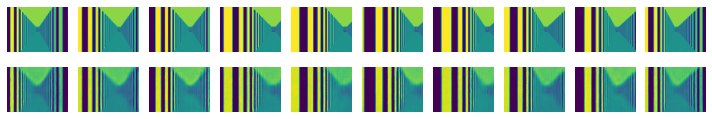

In [6]:
import random
import matplotlib.pyplot as plt

def plot_video_comparison(video, reconstructed_video):
    nb_frame = video.shape[0]
    fig, ax = plt.subplots(2, nb_frame, figsize=(nb_frame, 2))
    for i in range(video.shape[0]):
        ax[0, i].imshow(video[i, :, :])
        ax[0, i].axis("off")
    for i in range(video.shape[0]):
        ax[1, i].imshow(reconstructed_video[i, :, :])
        ax[1, i].axis("off")
    fig.tight_layout()

imgs = np.array(random.sample(list(data), 1))[0][20:30]
imgs_tensor = torch.tensor(imgs).to(device).float()
out_tensor, mu, logsigma = V_model(imgs_tensor)
out = out_tensor.cpu().detach().numpy()

plot_video_comparison(imgs.squeeze(1),out.squeeze(1))

In [7]:
from models.mdrnn import MDRNN

M_model = MDRNN(
            latent_dim=parameters["latent_dim_mdrnn"],
            action_dim=parameters["action_dim_mdrnn"],
            hidden_dim=parameters["hidden_dim_mdrnn"],
            gaussians_nb=parameters["gaussians_nb_mdrnn"],
        ).to(device)

print("number of parameters :", count_parameters(M_model))

number of parameters : 24873


In [8]:
optimizer = torch.optim.Adam(
        M_model.parameters(), lr=parameters["learning_rate_mdrnn"]
    )

In [9]:
nb_epochs = 30 # parameters["nb_epochs_mdrnn"]
for epoch in range(nb_epochs):
    pbar = tqdm(joint_loader)
    pbar.set_description("epoch %s/ loss=? " % str(epoch + 1))
    for obs,act in pbar:

        x = torch.reshape(obs, (-1, 1, 60, 80)).float().to(device)
        latents = V_model.encoder(x)[0]
        latents = torch.transpose(torch.reshape(latents, (-1, nb_steps, 20)), 0, 1)
        
        seq_len, batch_size, _ = latents.shape

        if M_model.memory == "rnn":
            hidden = torch.zeros(batch_size, M_model.hidden_dim).to(device)
        else:
            hidden = (
                torch.zeros(1,batch_size, M_model.hidden_dim).to(device),
                torch.zeros(1,batch_size, M_model.hidden_dim).to(device),
            )
        actions = torch.transpose(act,0,1).to(device)
        optimizer.zero_grad()
        episode_loss = []
        
        for t in range(seq_len - 1):
            latent = latents[t, :, :]
            action = actions[t,:,:]
            latent_next_obs = latents[t + 1, :, :]

            if M_model.memory == "rnn":
                mus, sigmas, logpi, next_hidden = M_model(action, latent, hidden)
                hidden = next_hidden[1].squeeze(0)
            else:
                mus, sigmas, logpi, next_hidden = M_model(action, latent, hidden)
                hidden = next_hidden

            loss = M_model.loss_function(mus, sigmas, logpi, latent_next_obs)
            episode_loss.append(loss)

        episode_loss = torch.stack(episode_loss).sum()
        episode_loss.backward()
        optimizer.step()

        pbar.set_description(
            "epoch "
            + str(epoch + 1)
            + "/"
            + str(nb_epochs)
            + "  loss= "
            + str(loss.cpu().detach().numpy())
        )



epoch 13/30  loss= 11.628963:  18%|█▊        | 45/250 [00:09<00:41,  4.98it/s]


KeyboardInterrupt: 

In [10]:
# save model
torch.save(M_model.state_dict(), "saved_models/mdrnn_"+parameters['rollout_type']+".pt")

In [ ]:
# load model
M_model.load_state_dict(torch.load("saved_models/mdrnn_"+parameters['rollout_type']+".pt"))

<All keys matched successfully>

In [ ]:
M_model.load_state_dict(torch.load("saved_models/mdrnn_rollout_constant_gain.pt"))

RuntimeError: Error(s) in loading state_dict for MDRNN:
	size mismatch for gmm_linear.weight: copying a param with shape torch.Size([41, 128]) from checkpoint, the shape in current model is torch.Size([205, 128]).
	size mismatch for gmm_linear.bias: copying a param with shape torch.Size([41]) from checkpoint, the shape in current model is torch.Size([205]).

### TEST

In [11]:

from plot_functions import plot_video_comparison,plot_SPE_metrics
from torch.distributions.normal import Normal

def gmm_loss(batch,mus,sigmas,logpi):

    batch = batch.unsqueeze(-2)
    normal_dist = Normal(mus, sigmas)
    g_log_probs = normal_dist.log_prob(batch)
    g_log_probs = logpi + torch.sum(g_log_probs, dim=-1)
    max_log_probs = torch.max(g_log_probs, dim=-1, keepdim=True)[0]
    g_log_probs = g_log_probs - max_log_probs

    g_probs = torch.exp(g_log_probs)
    probs = torch.sum(g_probs, dim=-1)

    log_prob = max_log_probs.squeeze() + torch.log(probs)

    return - log_prob


def run_model_prediction(video,act):

    loss = []
    video = np.transpose(video,(1,0,2,3))
    seq_len,batch_size,_,_ = video.shape
    video_tensor = torch.reshape(torch.tensor(video).float(),(-1,1,60,80)).float().to(device)
    reconstructed_video,latent_video, latent_video_variance  = V_model(video_tensor)
    latent_dim = latent_video.shape[-1]
    latent_video = torch.reshape(latent_video,(seq_len,batch_size,latent_dim))
    latent_video_variance = torch.reshape(latent_video_variance,(seq_len,batch_size,latent_dim))
    reconstructed_video = torch.reshape(reconstructed_video,(seq_len,batch_size,60,80))

    if M_model.memory == 'rnn':
        hidden = torch.zeros(batch_size, M_model.hidden_dim).to(device)
    else :
        hidden = (torch.zeros(1,batch_size, M_model.hidden_dim).to(device),
                        torch.zeros(1,batch_size, M_model.hidden_dim).to(device))

    actions = torch.transpose(torch.tensor(act),0,1).to(device)
    
    mean_pred = []
    sig_pred = []
    for t in range(seq_len):

        latent = latent_video[t,:,:]
        action = actions[t,:,:]

        if M_model.memory == 'rnn':

            mus, sigmas, logpi, next_hidden = M_model(action,latent,hidden)
            hidden = next_hidden[1].squeeze(0)
        else :
            mus, sigmas, logpi, next_hidden = M_model(action,latent,hidden)
            hidden = next_hidden

        if t < seq_len-1 :
            loss.append( gmm_loss(latent_video[t+1,:,:],mus,sigmas,logpi).cpu().detach().numpy() )


        mean_pred.append(mus[:,0,:].cpu().detach().numpy())
        sig_pred.append(sigmas[:,0,:].cpu().detach().numpy())

    loss = np.stack(loss).T
    predicted_latent = torch.tensor(mean_pred).to(device)
    predicted_latent = torch.reshape(predicted_latent,(-1,20))
    predicted_video = V_model.decoder(predicted_latent)
    predicted_video = torch.reshape(predicted_video,(seq_len,batch_size,60,80))
    
    mean_pred = np.array(mean_pred).transpose(1,0,2)
    sig_pred = np.array(sig_pred).transpose(1,0,2)
    latent_video = latent_video.cpu().detach().numpy().transpose(1,0,2)
    latent_video_variance = np.exp(latent_video_variance.cpu().detach().numpy()).transpose(1,0,2)
    reconstructed_video = reconstructed_video.cpu().detach().numpy().transpose(1,0,2,3)
    predicted_video = predicted_video.cpu().detach().numpy().transpose(1,0,2,3)
    
    return reconstructed_video,latent_video, latent_video_variance, mean_pred, sig_pred,predicted_video,loss

In [12]:
import gymnasium as gym
import miniworld
from miniworld.wrappers import PyTorchObsWrapper,GreyscaleWrapper
import numpy as np

In [24]:


control_args = dict(
        nb_sections=1,
        random_gain = False,
        motor_gains=[1],
        sections_length=[50],
        max_episode_steps=100,
    )

env = gym.make('MiniWorld-TaskHallwayControl-v0', 
                view="agent", render_mode=None,
                **control_args)
env = GreyscaleWrapper(env)

nb_control_trajectories = 100

trajectories_observations = []


for i_traj in range(nb_control_trajectories):

    gains = [1,0.5,1,1.5,0.5,1.5,1]
    gain_change_steps = [0,15,30,45,60,75,90]

    observations = []
    observation, info = env.reset()

    for i_step in range(control_args['max_episode_steps']-1):

        if (len(gain_change_steps) > 0) and (i_step == gain_change_steps[0]) :

            env.change_gain(random=False,gain=gains[0],glitch=True,glitch_phase = np.random.choice([-0.8,-0.6,-0.4,-0.2,0,0.2,0.4,0.6,0.8]))
            gain_change_steps.pop(0)
            gains.pop(0)

        action = 2 # env.action_space.sample()  # agent policy that uses the observation and info
        observation, reward, terminated, truncated, info = env.step(action)
        if terminated or truncated:
            print(oups)
            observation, info = env.reset()

        observations.append(observation)

    

    observations = np.stack(observations).squeeze(-1)
    actions = np.ones(control_args['max_episode_steps'])*2

    trajectories_observations.append(observations)
    
env.close()

trajectories_observations = np.stack(trajectories_observations) / 255
trajectories_actions = np.zeros((nb_control_trajectories,control_args['max_episode_steps'],3))
trajectories_actions[:,:,2] = 1
trajectories_actions = np.array(trajectories_actions,dtype=np.int32)
trajectories_observations = np.array(trajectories_observations,dtype=np.float32)
print(trajectories_observations.shape)
print(trajectories_actions.shape)

(100, 99, 60, 80)
(100, 100, 3)


In [25]:

reconstructed_video,latent_video, latent_video_variance, mean_pred, sig_pred,predicted_video,loss = run_model_prediction(trajectories_observations,trajectories_actions)

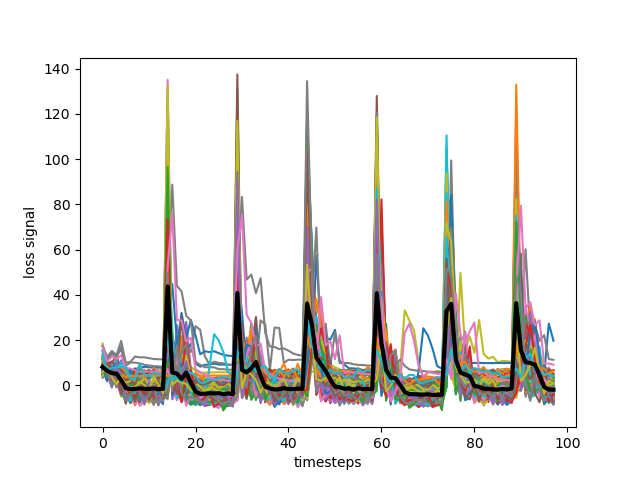

In [26]:
plt.figure()
plt.plot(loss.T)
plt.plot(np.mean(loss,axis=0),color='k',lw=3)
plt.xlabel('timesteps')
plt.ylabel('loss signal')
plt.show()

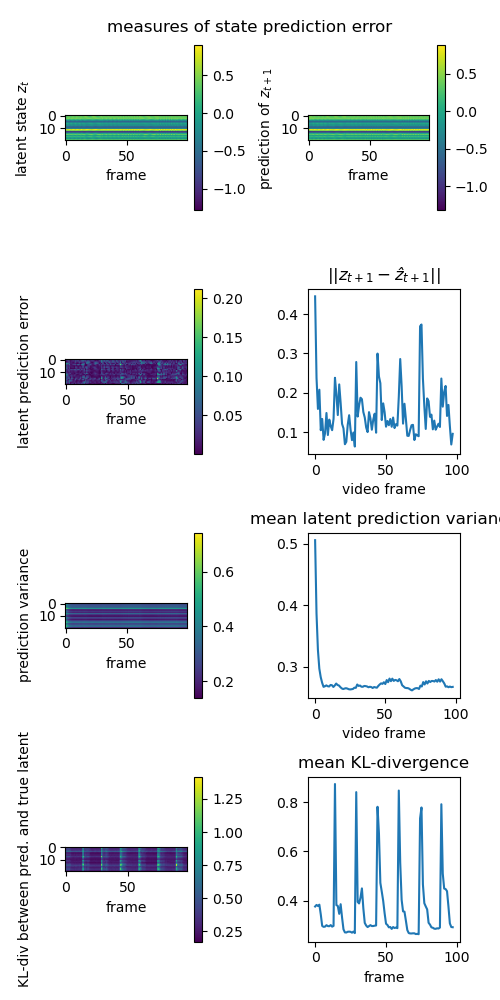

In [27]:
%matplotlib widget
plot_SPE_metrics(latent_video, latent_video_variance, mean_pred, sig_pred)

### Analysis replications

In [31]:
# split by gain change amplitude

nb_steps = 50
control_args = dict(
        nb_sections=1,
        random_gain = False,
        motor_gains=[1],
        sections_length=[50],
        max_episode_steps=nb_steps+2,
    )

env = gym.make('MiniWorld-TaskHallwayControl-v0', 
                view="agent", render_mode=None,
                **control_args)
env = GreyscaleWrapper(env)

nb_control_trajectories = 50


gains_test = [0.5,1,1.5]

losses = np.zeros((3,3,nb_control_trajectories,nb_steps))
SPE_norms = np.zeros((3,3,nb_control_trajectories,nb_steps))

traj_steps = np.random.randint(15,35,size=nb_control_trajectories)

loss_0 = []
loss_m1 = []
loss_m2 = []
loss_1 = []
loss_2 = []

SPE_0 = []
SPE_m1 = []
SPE_m2 = []
SPE_1 = []
SPE_2 = []

random_change_step = True

for i,gain_pre in enumerate(gains_test) :
    for j,gain_post in enumerate(gains_test):

        trajectories_observations = []

        for i_traj in range(nb_control_trajectories):
            
            gains = [gain_pre,gain_post]
            if random_change_step :
                gain_change_steps = [0,traj_steps[i_traj]]
            else :
                gain_change_steps = [0,15]
            observations = []
            observation, info = env.reset()
            for i_step in range(control_args['max_episode_steps']-1):
                if (len(gain_change_steps) > 0) and (i_step == gain_change_steps[0]) :
                    env.change_gain(random=False,gain=gains[0],glitch=True,glitch_phase=np.random.choice([-0.8,-0.6,-0.4,-0.2,0,0.2,0.4,0.6,0.8]))
                    gain_change_steps.pop(0)
                    gains.pop(0)
                action = 2 # env.action_space.sample()  # agent policy that uses the observation and info
                observation, reward, terminated, truncated, info = env.step(action)
                if terminated or truncated:
                    print("oups")
                    observation, info = env.reset()
                observations.append(observation)

            observations = np.stack(observations).squeeze(-1)
            actions = np.ones(control_args['max_episode_steps'])*2

            trajectories_observations.append(observations)
            

        trajectories_observations = np.stack(trajectories_observations) / 255
        trajectories_actions = np.zeros((nb_control_trajectories,control_args['max_episode_steps'],3))
        trajectories_actions[:,:,2] = 1
        trajectories_actions = np.array(trajectories_actions,dtype=np.int32)
        trajectories_observations = np.array(trajectories_observations,dtype=np.float32)

        reconstructed_video,latent_video, latent_video_variance, mean_pred, sig_pred,predicted_video,loss = run_model_prediction(trajectories_observations,trajectories_actions)
        losses[i,j] = loss

        z = latent_video
        z_pred = mean_pred

        # first measure of SPE : norm between z_t and mean of P(z_t|h_t-1)
        z_error = np.abs(z_pred[:,:-1,:] - z[:,1:,:])
        spe_norm = np.linalg.norm(z_error,axis=-1)

        # z_error_norm = np.linalg.norm(z_error, axis=0)
        SPE_norms[i,j] = spe_norm
        
        if i-j == 0:
            loss_0.append(loss)
            SPE_0.append(spe_norm)
        elif i-j == -1:
            loss_m1.append(loss)
            SPE_m1.append(spe_norm)
        elif i-j == -2:
            loss_m2.append(loss)
            SPE_m2.append(spe_norm)
        elif i-j == 1:
            loss_1.append(loss)
            SPE_1.append(spe_norm)
        else :
            loss_2.append(loss)
            SPE_2.append(spe_norm)

env.close()

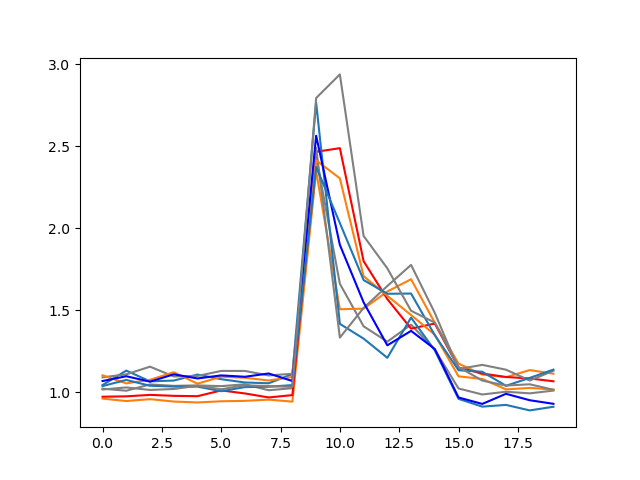

In [35]:
plt.figure()
color_dict = { "-2": 'blue',
               "-1": 'tab:blue',
               "0": 'grey',
               "1": 'tab:orange',
               "2":'red' }
relative_gain_change_color = ['blue','tab:blue','grey','tab:orange','red']

for i in range(3):
    for j in range(3):
        diff = str(j-i)
        aligned_loss = []
        for i_traj in range(nb_control_trajectories):
            aligned_loss.append( SPE_norms[i,j,i_traj,traj_steps[i_traj]-10:traj_steps[i_traj]+10] )
        plt.plot( np.mean(aligned_loss,axis=0),color = color_dict[diff],label=diff)

plt.show()


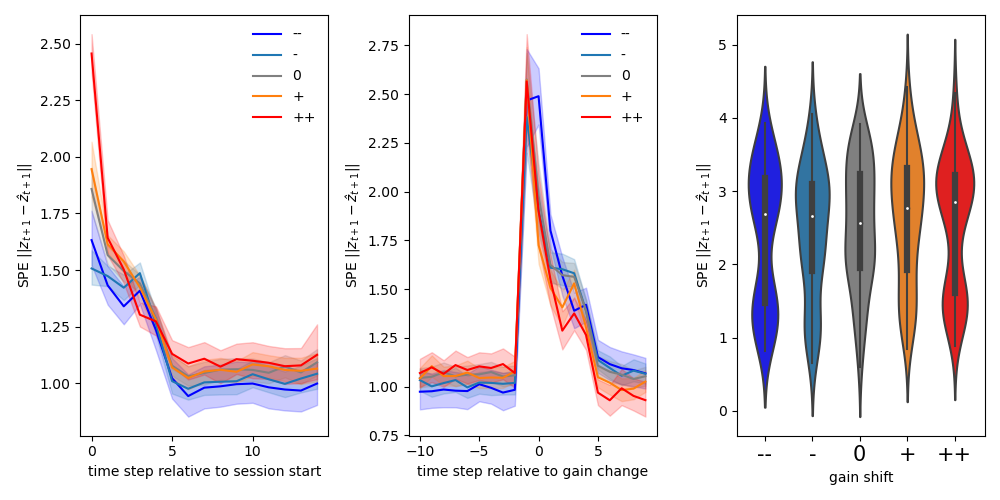

In [34]:
import seaborn as sns

plt.figure(figsize=(10,5))

relative_gain_change_losses =   [SPE_m2,SPE_m1,SPE_0,SPE_1,SPE_2] #  [loss_m2,loss_m1,loss_0,loss_1,loss_2] #

relative_gain_change_label = ['--','-','0','+','++']
relative_gain_change_color = ['blue','tab:blue','grey','tab:orange','red']

plt.subplot(131)
for i,loss in enumerate(relative_gain_change_losses):
    aligned_loss = []
    for l in range(len(loss)):
        for i_traj in range(nb_control_trajectories):
            aligned_loss.append( loss[l][i_traj,0:15])
    # plt.plot(np.arange(0,15),np.mean(aligned_loss,axis=0),color = relative_gain_change_color[i],label=relative_gain_change_label[i])
    sns.lineplot(x = np.tile(np.arange(0,15), np.array(aligned_loss).flatten().shape[0] // 15), y = np.array(aligned_loss).flatten(),color = relative_gain_change_color[i],label=relative_gain_change_label[i])

plt.xlabel('time step relative to session start')
plt.ylabel(r"SPE $||z_{t+1} - ẑ_{t+1}||$")
plt.legend(frameon=False)


plt.subplot(132)
relative_gain_change_peak_vals = []
for i,loss in enumerate(relative_gain_change_losses):
    aligned_loss = []
    for l in range(len(loss)):
        for i_traj in range(nb_control_trajectories):
            aligned_loss.append( loss[l][i_traj,traj_steps[i_traj]-10:traj_steps[i_traj]+10])
    peak_val = np.array(aligned_loss)[:,9]
    relative_gain_change_peak_vals.extend(peak_val)

    # plt.plot(np.arange(-10,10),np.mean(aligned_loss,axis=0),color = relative_gain_change_color[i],label=relative_gain_change_label[i])
    sns.lineplot(x = np.tile(np.arange(-10,10), np.array(aligned_loss).flatten().shape[0] // 20), y = np.array(aligned_loss).flatten(),color = relative_gain_change_color[i],label=relative_gain_change_label[i])

plt.xlabel('time step relative to gain change')
plt.ylabel(r"SPE $||z_{t+1} - ẑ_{t+1}||$")
plt.legend(frameon=False)

plt.subplot(133)

sns.violinplot(x=list(np.repeat(range(5),len(relative_gain_change_peak_vals) //5)),y=relative_gain_change_peak_vals,palette = relative_gain_change_color)

plt.xticks(ticks=[0,1,2,3,4],labels=['--','-','0','+','++'],fontsize=15)
plt.xlabel('gain shift')
plt.ylabel(r"SPE $||z_{t+1} - ẑ_{t+1}||$")
plt.plot()

plt.tight_layout()